In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
from numpy import sqrt, cosh, cos, sinh
sns.set(style="darkgrid")

from utils.root2df import Root2Df

In [2]:
res = Root2Df(data_dir=Path('../data/raw')).read_df()
res.keys()

[INFO] Reading skim configuration file: ..\data\raw\processing.cfg
[INFO] ..\data\raw\MinBiasPU200_MTD.root loaded!
[INFO] ..\data\raw\DsTau3muPU0_Private.root loaded!
[INFO] ..\data\raw\DsTau3muPU200_MTD.root loaded!


dict_keys(['MinBiasPU200_MTD', 'DsTau3muPU0_Private', 'DsTau3muPU200_MTD'])

In [3]:
neg200 = res['MinBiasPU200_MTD']
pos0 = res['DsTau3muPU0_Private']
pos200 = res['DsTau3muPU200_MTD']
pos0 = pos0[pos0.n_gen_tau == 1].reset_index(drop=True)
pos200 = pos200[pos200.n_gen_tau == 1].reset_index(drop=True)
len(neg200), len(pos0), len(pos200)

(499600, 77595, 77883)

In [24]:
def filter_mu_by_pt_eta(x):
    return ((x['gen_mu_pt'] > 0.5).sum() == 3) and ((abs(x['gen_mu_eta']) < 2.8).sum() == 3) and ((abs(x['gen_mu_eta']) > 1.2).sum() == 3)

pos0 = pos0[pos0.apply(lambda x: filter_mu_by_pt_eta(x), axis=1)].reset_index(drop=True)
pos200 = pos200[pos200.apply(lambda x: filter_mu_by_pt_eta(x), axis=1)].reset_index(drop=True)
len(neg200), len(pos0), len(pos200)

(499600, 14892, 14624)

In [8]:
# neg200 = neg200[neg200.n_mu_hit >= 3].reset_index(drop=True)
# pos0 = pos0[pos0.n_mu_hit >= 3].reset_index(drop=True)
# pos200 = pos200[pos200.n_mu_hit >= 3].reset_index(drop=True)

(496468, 41697, 77767)

In [9]:
print((pos0.n_mu_hit == 0).sum() / len(pos0), (pos0.n_mu_hit == 1).sum() / len(pos0), (pos0.n_mu_hit == 2).sum() / len(pos0), (pos0.n_mu_hit >= 3).sum() / len(pos0))
print((pos200.n_mu_hit == 0).sum() / len(pos200), (pos200.n_mu_hit == 1).sum() / len(pos200), (pos200.n_mu_hit == 2).sum() / len(pos200), (pos200.n_mu_hit >= 3).sum() / len(pos200))

0.0 0.0 0.0 1.0
0.0 0.0 0.0 1.0


In [ ]:
def get_mixed_df(pos0, neg200, random_state):
    tqdm.pandas()
    def concat_one_entry(entry):
        for k, v in entry.items():
            if isinstance(v, int) and 'gen' not in k:
                assert k == 'n_mu_hit'
                entry[k] += noise_in_mixed_pos.iloc[entry.name][k]
            elif 'gen' not in k:
                assert isinstance(v, np.ndarray)
                entry[k] = np.concatenate((noise_in_mixed_pos.iloc[entry.name][k], v))
        return entry.values

    neg_idx = np.arange(len(neg200))
    np.random.seed(random_state)
    np.random.shuffle(neg_idx)

    noise_in_mixed_pos = neg200.iloc[neg_idx[:len(pos0)]].reset_index(drop=True)
    pure_neg = neg200.iloc[neg_idx[len(pos0):]].reset_index(drop=True)

    mixed_pos = pd.DataFrame(data=pos0.progress_apply(lambda x: concat_one_entry(x), axis=1).to_list(), columns=pos0.columns)
    return mixed_pos, pure_neg

mixed_pos, pure_neg = get_mixed_df(pos0, neg200, 1)
len(mixed_pos)

In [25]:
neg200 = neg200[neg200.apply(lambda x: (x.mu_hit_station == 1).sum(), axis=1) >= 2].reset_index(drop=True)
pos0 = pos0[pos0.apply(lambda x: (x.mu_hit_station == 1).sum(), axis=1) >= 2].reset_index(drop=True)
pos200 = pos200[pos200.apply(lambda x: (x.mu_hit_station == 1).sum(), axis=1) >= 2].reset_index(drop=True)
# mixed_pos = mixed_pos[mixed_pos.apply(lambda x: (x.mu_hit_station == 1).sum(), axis=1) >= 3].reset_index(drop=True)
len(neg200), len(pos0), len(pos200) #, len(mixed_pos)

(498071, 12802, 14621)

In [8]:
neg200.describe()

,n_mu_hit
count,499342.000000
mean,20.350137
std,11.249210
min,1.000000
25%,12.000000
50%,18.000000
75%,27.000000
max,113.000000


In [9]:
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999
neg200.head()

,n_mu_hit,mu_hit_endcap,mu_hit_station,mu_hit_ring,mu_hit_sector,mu_hit_subsector,mu_hit_chamber,mu_hit_cscid,mu_hit_bx,mu_hit_type,mu_hit_neighbor,mu_hit_strip,mu_hit_wire,mu_hit_roll,mu_hit_quality,mu_hit_pattern,mu_hit_bend,mu_hit_sim_phi,mu_hit_sim_theta,mu_hit_sim_eta,mu_hit_sim_r,mu_hit_sim_z
0,17,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1]","[1, 2, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 4, 4, 4, 4, 1]","[1, 2, 2, 2, 2, 2, 2, 3, 5, 6, 1, 2, 3, 3, 4, 4, 6]","[0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 0]","[4, 7, 7, 12, 12, 4, 12, 7, 16, 16, 4, 4, 18, 20, 23, 20, 18]","[3, 3, 3, 4, 4, 3, 7, 3, 3, 3, 3, 3, 1, 3, 3, 3, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[4, 3, 4, 1, 2, 4, 2, 3, 4, 4, 4, 4, 1, 1, 1, 1, 4]","[0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0]","[372, 361, 640, 116, 7, 372, 7, 361, 526, 526, 480, 480, 80, 12, 68, 12, 651]","[-99, -99, -99, 7, -99, -99, -99, -99, -99, -99, -99, -99, 3, 7, 3, 7, -99]","[14, 1, 2, -99, 3, 14, 3, 1, 14, 14, 14, 14, -99, -99, -99, -99, 11]","[4, 2, 4, 4, 1, 4, 1, 2, 4, 4, 4, 4, 5, 5, 4, 5, 5]","[0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 4, 4, 0]","[33, -99, -60, 31, -99, 33, -99, -99, -84, -84, 83, 83, -16, -32, -32, -32, -29]","[60.30256, 115.76586, 113.28259, 112.534706, 112.979836, 60.30256, 107.02649, 115.76586, -63.743744, -63.743744, 62.537193, 62.537193, 166.38872, -165.94212, -142.16267, -165.94212, -12.997323]","[7.024292, 21.46307, 13.427252, 23.394432, 24.54635, 7.024292, 20.15554, 21.46307, 7.039067, 7.039067, 172.96898, 172.96898, 169.09969, 167.03917, 169.47531, 167.03917, 171.21321]","[2.790746, 1.6632497, 2.1394963, 1.5748464, 1.5253502, 2.790746, 1.7275075, 1.6632497, 2.7886398, 2.7886398, -2.7897866, -2.7897866, -2.3495607, -2.1751657, -2.384833, -2.1751657, -2.5661626]","[66.16643, 312.96072, 128.20139, 295.85043, 317.37912, 66.16643, 356.32977, 312.96072, 66.30701, 66.30701, 66.23043, 66.23043, 112.929276, 134.9747, 114.39374, 134.9747, 83.00519]","[537.0, 796.0012, 537.0, 683.85236, 694.9346, 537.0, 970.8, 796.0012, 537.0, 537.0, -537.0, -537.0, -586.41644, -586.4688, -615.7326, -586.4688, -537.0]"
1,18,"[1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 1]","[2, 3, 3, 3, 4, 4, 4, 1, 1, 2, 2, 2, 3, 3, 3, 4, 5, 6]","[0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 2, 2, 0, 2, 2, 0, 0, 2]","[8, 11, 9, 8, 23, 11, 11, 3, 2, 10, 14, 14, 9, 14, 14, 13, 13, 2]","[1, 1, 2, 1, 3, 1, 1, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[4, 4, 4, 4, 1, 4, 4, 4, 3, 3, 1, 1, 1, 1, 1, 4, 4, 3]","[0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]","[576, 740, 735, 576, 18, 372, 740, 516, 78, 100, 86, 58, 92, 86, 58, 672, 672, 78]","[-99, -99, -99, -99, 3, -99, -99, -99, -99, -99, 12, 12, 27, 12, 12, -99, -99, -99]","[14, 12, 13, 14, -99, 13, 12, 10, 6, 7, -99, -99, -99, -99, -99, 13, 13, 6]","[5, 6, 5, 5, 4, 4, 6, 4, 2, 1, 5, 4, 6, 5, 4, 4, 4, 2]","[0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 8, 4, 10, 8, 4, 0, 0, 0]","[-84, -12, -11, -84, -16, 73, -12, 103, -99, -99, -16, -27, -2, -16, -27, 57, 57, -99]","[134.94858, -169.29683, 150.83134, 134.94858, -143.28792, -159.69745, -169.29683, 43.481697, 10.900708, 89.76156, 128.124, 128.92888, 163.2656, 128.124, 128.92888, -112.45369, -112.45369, 10.900708]","[7.051308, 7.934151, 7.9313025, 7.051308, 10.423433, 7.831342, 7.934151, 171.26187, 164.23016, 165.40529, 166.34566, 166.23337, 167.37799, 166.34566, 166.23337, 172.10121, 172.10121, 164.23016]","[2.7868977, 2.6685982, 2.6689582, 2.7868977, 2.3945544, 2.6816816, 2.6685982, -2.5717366, -1.9769338, -2.0552866, -2.1225677, -2.1142988, -2.2018766, -2.1225677, -2.1142988, -2.6730788, -2.6730788, -1.9769338]","[66.42349, 74.84117, 74.81396, 66.42349, 113.269775, 73.85914, 74.84117, 82.53835, 159.66187, 147.21191, 142.44106, 143.66447, 188.05042, 142.44106, 

In [10]:
pos0.describe()

,n_gen_tau,n_gen_mu,n_mu_hit
count,14230.0,14230.0,14230.000000
mean,1.0,3.0,12.571680
std,0.0,0.0,10.117923
min,1.0,3.0,1.000000
25%,1.0,3.0,4.000000
50%,1.0,3.0,10.000000
75%,1.0,3.0,18.000000
max,1.0,3.0,69.000000


In [11]:
pos0.head()

,n_gen_tau,n_gen_mu,n_mu_hit,gen_mu_pt,gen_mu_eta,gen_mu_phi,gen_mu_charge,gen_mu_gentauidx,gen_tau_pt,gen_tau_eta,gen_tau_phi,gen_tau_e,gen_tau_charge,mu_hit_endcap,mu_hit_station,mu_hit_ring,mu_hit_sector,mu_hit_subsector,mu_hit_chamber,mu_hit_cscid,mu_hit_bx,mu_hit_type,mu_hit_neighbor,mu_hit_strip,mu_hit_wire,mu_hit_roll,mu_hit_quality,mu_hit_pattern,mu_hit_bend,mu_hit_sim_phi,mu_hit_sim_theta,mu_hit_sim_eta,mu_hit_sim_r,mu_hit_sim_z
0,1,3,14,"[1.2961711, 1.1655244, 2.072843]","[1.4696344, 1.2817779, 1.8989797]","[-2.0093365, -1.3892938, -1.4018095]","[-1, -1, 1]","[0, 0, 0]",[4.363222],[1.6861544],[-1.5688192],[12.310819],[-1],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 2, 3, 3, 4, 4, 1, 1, 2, 3, 3, 4, 4]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5]","[0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]","[14, 26, 13, 13, 13, 13, 13, 14, 26, 13, 13, 13, 13, 13]","[1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[4, 1, 1, 1, 2, 1, 2, 4, 1, 1, 1, 2, 1, 2]","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]","[669, 64, 46, 115, 28, 104, 36, 669, 64, 46, 115, 28, 104, 36]","[-99, 15, 24, 15, -99, 3, -99, -99, 15, 24, 15, -99, 3, -99]","[0, -99, -99, -99, 4, -99, 5, 0, -99, -99, -99, 4, -99, 5]","[4, 6, 4, 6, 2, 4, 2, 4, 6, 4, 6, 2, 4, 2]","[0, 4, 10, 10, 0, 10, 0, 0, 4, 10, 10, 0, 10, 0]","[-85, -23, -4, 4, -99, 6, -99, -85, -23, -4, 4, -99, 6, -99]","[-107.46873, -110.03094, -119.39784, -119.79477, -119.18491, -118.33005, -117.50734, -107.46873, -110.03094, -119.39784, -119.79477, -119.18491, -118.33005, -117.50734]","[14.946168, 14.734521, 12.340921, 11.6143055, 11.448174, 10.663172, 10.463079, 14.946168, 14.734521, 12.340921, 11.6143055, 11.448174, 10.663172, 10.463079]","[2.031226, 2.0456486, 2.224577, 2.2857041, 2.300209, 2.371686, 2.390737, 2.031226, 2.0456486, 2.224577, 2.2857041, 2.300209, 2.371686, 2.390737]","[143.34808, 154.24153, 183.73831, 189.88434, 195.32138, 190.8931, 194.82867, 143.34808, 154.24153, 183.73831, 189.88434, 195.32138, 190.8931, 194.82867]","[537.0, 586.4939, 839.8178, 923.8732, 964.5, 1013.8448, 1054.995, 537.0, 586.4939, 839.8178, 923.8732, 964.5, 1013.8448, 1054.995]"
1,1,3,1,"[0.5189667, 1.6553686, 1.4908375]","[1.7326839, 1.5994622, 1.464328]","[-1.1720272, -2.6159642, -2.6565108]","[1, 1, -1]","[0, 0, 0]",[3.2426312],[1.6806738],[-2.4753795],[9.180674],[1],[1],[1],[1],[5],[1],[28],[2],[0],[1],[0],[38],[34],[-99],[4],[3],[31],[-92.07414],[19.699387],[1.7508671],[209.95796],[586.4096]
2,1,3,12,"[2.2071426, 0.61932427, 1.0401739]","[-2.1234264, -2.5167837, -1.4970624]","[1.2900697, 1.9525367, 1.0761985]","[-1, -1, 1]","[0, 0, 0]",[3.7153943],[-2.110964],[1.3331883],[15.663624],[-1],"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]","[1, 1, 2, 1, 2, 2, 3, 3, 3, 4, 4, 4]","[4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[10, 10, 6, 6, 6, 6, 5, 6, 6, 5, 5, 5]","[2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 3, 3, 4, 1, 1, 2, 1, 1, 1, 1, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[21, 50, 357, 64, 147, 147, 3, 1, 1, 145, 145, 6]","[7, -99, -99, -99, 18, 19, -99, 21, 20, 15, 14, -99]","[-99, 8, 7, 2, -99, -99, 4, -99, -99, -99, -99, 4]","[6, 1, 1, 6, 6, 6, 3, 5, 5, 6, 6, 2]","[10, 0, 0, 0, 10, 10, 0, 10, 10, 10, 10, 0]","[-4, -99, -99, 57, 0, 0, -99, 3, 3, 4, 4, -99]","[92.94546, 92.40949, 96.00624, 91.6537, 95.93394, 95.933914, 94.45099, 94.59391, 94.59389, 93.795555, 93.79549, 93.73641]","[167.18918, 166.47693, 167.84035, 166.52402, 167.80562, 167.6996, 167.95995, 167.99438, 168.08604, 168.19885, 168.28432, 168.15845]","[-2.1869059, -2.1323195, -2.239487, -2.1358404, -2.2366138, -2.2278914, -2.2494466, -2.252332, -2.2600508, -2.2696326, -2.2769532, -2.266191]","[133.35165, 135.97385, 170.99734, 128.68423, 176.10678, 177.68599, 205.71547, 201.80206, 200.216, 211.75873, 210.18083, 221.19855]","[-586.4368, -565.3688, -7

In [12]:
pos200.describe()

,n_gen_tau,n_gen_mu,n_mu_hit
count,14623.0,14623.0,14623.000000
mean,1.0,3.0,32.629419
std,0.0,0.0,15.452281
min,1.0,3.0,1.000000
25%,1.0,3.0,21.000000
50%,1.0,3.0,31.000000
75%,1.0,3.0,41.000000
max,1.0,3.0,137.000000


In [13]:
pos200.head()

,n_gen_tau,n_gen_mu,n_mu_hit,gen_mu_pt,gen_mu_eta,gen_mu_phi,gen_mu_charge,gen_mu_gentauidx,gen_tau_pt,gen_tau_eta,gen_tau_phi,gen_tau_e,gen_tau_charge,mu_hit_endcap,mu_hit_station,mu_hit_ring,mu_hit_sector,mu_hit_subsector,mu_hit_chamber,mu_hit_cscid,mu_hit_bx,mu_hit_type,mu_hit_neighbor,mu_hit_strip,mu_hit_wire,mu_hit_roll,mu_hit_quality,mu_hit_pattern,mu_hit_bend,mu_hit_sim_phi,mu_hit_sim_theta,mu_hit_sim_eta,mu_hit_sim_r,mu_hit_sim_z
0,1,3,39,"[2.0681932, 0.6984228, 1.0846201]","[2.189482, 2.0569768, 1.628002]","[-2.8237374, -2.8499565, -1.9614837]","[-1, -1, 1]","[0, 0, 0]",[3.5643215],[2.1085608],[-2.5958493],[15.000532],[-1],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 3, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 4, 4, 1, 1, 4, 1, 1, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 2, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1]","[1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 4, 5, 5, 6, 6]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1]","[2, 2, 2, 13, 14, 14, 19, 14, 14, 22, 23, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 2, 2, 2, 6, 4, 8, 8, 8, 8, 8, 8, 8, 8, 14, 14, 14, 34, 34]","[3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 1, 5, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 2, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 4, 4, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 3]","[1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]","[121, 50, 50, 115, 9, 36, 179, 9, 36, 89, 3, 57, 622, 654, 25, 134, 25, 134, 125, 37, 127, 121, 50, 50, 159, 90, 76, 71, 76, 71, 76, 71, 76, 71, 70, 440, 70, 25, 32]","[-99, 7, 6, 17, 24, 24, -99, 24, 24, 4, 10, -99, -99, -99, 14, 14, 13, 13, 14, -99, 11, -99, 7, 6, -99, 45, 7, 7, 6, 6, 7, 7, 6, 6, -99, -99, -99, 13, -99]","[8, -99, -99, -99, -99, -99, 7, -99, -99, -99, -99, 7, 3, 13, -99, -99, -99, -99, -99, 4, -99, 8, -99, -99, 1, -99, -99, -99, -99, -99, -99, -99, -99, -99, 14, 4, 14, -99, 6]","[2, 4, 4, 5, 5, 4, 2, 5, 4, 4, 6, 1, 6, 4, 5, 6, 5, 6, 5, 2, 5, 2, 4, 4, 5, 4, 6, 5, 6, 5, 6, 5, 6, 5, 4, 4, 4, 5, 1]","[0, 6, 6, 10, 4, 10, 0, 4, 10, 9, 10, 0, 0, 0, 10, 10, 10, 10, 10, 0, 10, 0, 6, 6, 0, 9, 7, 2, 7, 2, 7, 2, 7, 2, 0, 0, 0, 7, 0]","[-99, -16, -16, -2, -27, 0, -99, -27, 0, 7, 6, -99, 35, 44, 3, 0, 3, 0, 0, -99, 0, -99, -16, -16, -99, 13, 16, -3, 16, -3, 16, -3, 16, -3, -89, 60, -89, 13, -99]","[11.377402, 10.283711, 10.283821, 124.36202, 125.29837, 128.71303, 175.558, 125.29837, 128.71303, -145.39362, -144.96266, -142.3295, -146.24988, -147.08041, -142.19926, -127.66155, -142.19923, -127.66149, -141.12793, -141.1599, -141.39922, 11.377402, 10.283711, 10.283821, 46.639175, 29.268118, 66.83458, 67.50049, 66.83459, 67.50047, 66.83458, 67.50049, 66.83459, 67.50047, -108.1917, -98.513855, -108.1917, -26.716642, -26.639174]","[13.515317, 12.4771595, 12.1828985, 15.281699, 16.649635, 17.126322, 14.415843, 16.649635, 17.126322, 12.104973, 12.163897, 12.110602, 13.415257, 7.890658, 11.711821, 11.71637, 11.605816, 11.61032, 11.250066, 11.0697565, 11.123816, 13.515317, 12.4771595, 12.1828985, 156.84315, 150.14609, 167.89944, 167.83235, 168.18503, 168.11943, 167.89944, 167.83235, 168.18503, 168.11943, 172.90413, 168.0061, 172.90413, 165.34491, 164.2062]","[2.1328986, 2.2135115, 2.2375634, 2.0087652, 1.921914, 1.8932728, 2.0677512, 1.921914, 1.8932728, 2.2440283, 2.239136, 2.24356, 2.1403983, 2.6741123, 2.277285, 2.2768939, 2.2864404, 2.2860496, 2.31778, 2.33404, 2.3291378, 2.1328986, 2.2135115, 2.2375634, -1.58534, -1.3220688, -2.2443955, -2.2388253, -2.2684536, -2.2628772, -2.2443955, 

In [14]:
m = 0.10563

def square_mij(pt_i, pt_j, eta_i, eta_j, phi_i, phi_j):
    first_term = 2 * m**2
    second_term = 2 * sqrt(m**2 + pt_i**2 * cosh(eta_i)**2) * sqrt(m**2 + pt_j**2 * cosh(eta_j)**2)
    third_term = -2 * pt_i * pt_j * (sinh(eta_i) * sinh(eta_j) + cos(phi_i - phi_j))
    return first_term + second_term + third_term

def square_M3mu(sq_m12, sq_m23, sq_m13):
    return sq_m12 + sq_m23 + sq_m13 - 3 * m**2

def invariant_mass(pts, etas, phis):
    pt1, pt2, pt3 = pts
    eta1, eta2, eta3 = etas
    phi1, phi2, phi3 = phis

    sq_m12 = square_mij(pt1, pt2, eta1, eta2, phi1, phi2)
    sq_m23 = square_mij(pt2, pt3, eta2, eta3, phi2, phi3)
    sq_m13 = square_mij(pt1, pt3, eta1, eta3, phi1, phi3)


    return sqrt(square_M3mu(sq_m12, sq_m23, sq_m13))

pts = [1.65537, 1.49084, 0.518967]
etas = [1.59946, 1.46433, 1.73268]
phis = [-2.61596, -2.65651, -1.17203]

assert abs(invariant_mass(pts, etas, phis) - 1.77682) < 1e-4

In [15]:
def invariant_mass_check(df):
    errs = []
    for i in tqdm(range(len(df))):
        if df.gen_mu_pt[i].shape == (3,):
            idx = (df.gen_mu_pt[i] * -1).argsort()
            mass = invariant_mass(df.gen_mu_pt[i][idx], df.gen_mu_eta[i][idx], df.gen_mu_phi[i][idx])

            err = abs(mass - 1.7768)
            assert err < 1e-1
            errs.append(err)
    print(np.mean(errs))

In [16]:
invariant_mass_check(pos0)
invariant_mass_check(pos200)

 14%|██████████████████▋                                                                                                                   | 2038/14623 [00:00<00:01, 10118.28it/s]

6.676944975274421e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14623/14623 [00:01<00:00, 10193.52it/s]

6.180320009477888e-06


In [8]:
palette = 'bright'
def concat_array_to_df(arrays, names):
    dfs = []
    for idx, array in enumerate(arrays):
        name = [names[idx]] * len(array)
        dfs.append(pd.DataFrame(data={'value': array, 'name': name}))
    return pd.concat(dfs, ignore_index=True)

def plot_tau_prop(dfs, names):
    print('[INFO] Plotting tau_prop')
    keys = ['gen_tau_pt', 'gen_tau_eta', 'gen_tau_phi']
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))

    for i, key in enumerate(keys):
        values = [np.stack(df[key]).reshape(-1) for df in dfs]
        df = concat_array_to_df(values, names)
        
        cumulative = False
        title = key
        if key == 'gen_tau_pt':
            axes[i].set_xlim(0, 8)
        elif key == 'gen_tau_eta':
            axes[i].set_xlim(-5, 5)
        elif key == 'gen_tau_phi':
            cumulative = True
            title += '-cdf'
        axes[i].set_title(title)
            
        sns.histplot(data=df, x='value', hue='name', fill=False, element='step', stat="density", common_norm=False, cumulative=cumulative, ax=axes[i], palette=palette)
        
    plt.show()
    
def plot_mu_prop(dfs, names):
    print('[INFO] Plotting mu_prop')
    keys = ['gen_mu_pt', 'gen_mu_eta', 'gen_mu_phi']
    orders = ['lead', 'secd', 'soft']
    for key in keys:
        sorted_values = [np.stack(df.apply(lambda x: x[key][np.argsort(x.gen_mu_pt*-1)], axis=1)) for df in dfs]

        fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 3))
        for i, order in enumerate(orders):
            df = concat_array_to_df([value[:, i] for value in sorted_values], names)
            
            cumulative = False
            title = order + '_' + key
            if key == 'gen_mu_pt':
                axes[i].set_xlim(0, 4)
            elif key == 'gen_mu_eta':
                axes[i].set_xlim(-5, 5)
            elif key == 'gen_mu_phi':
                cumulative = True
                title += '-cdf'
            axes[i].set_title(title)
            
            sns.histplot(data=df, x='value', hue='name', fill=False, element='step', stat="density", common_norm=False, ax=axes[i], cumulative=cumulative, palette=palette)

        plt.show()
        
def plot_mu_hits(dfs, names):
    print('[INFO] Plotting mu_hits')
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    values = [np.stack(df['n_mu_hit']).reshape(-1) for df in dfs]
    df = concat_array_to_df(values, names)
    sns.histplot(data=df, x='value', hue='name', stat="probability", fill=True, common_norm=False, discrete=True, ax=axes[0], palette=palette)
    axes[0].set_xlim(0, 70)
    axes[0].set_title('n_mu_hit')
    
    values = [df.apply(lambda x: (x['mu_hit_station'] == 1).sum(), axis=1).to_numpy().reshape(-1) for df in dfs]
    df = concat_array_to_df(values, names)
    sns.histplot(data=df, x='value', hue='name', stat="probability", fill=True, common_norm=False, discrete=True, ax=axes[1], palette=palette)
    axes[1].set_xlim(0, 70)
    axes[1].set_title('station' + str(1))
    plt.show()
    
    for idx, name in enumerate(names):
        if name == 'pos0':
            values = [np.stack(dfs[idx]['n_mu_hit']).reshape(-1)]
            df = concat_array_to_df(values, names)
            sns.histplot(data=df, x='value', hue='name', stat="probability", fill=True, common_norm=False, discrete=True, palette=palette)
            plt.xlim(0, 10)
            plt.title('n_mu_hit-pos0')
            plt.show()
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    for i in tqdm(range(3)):

        values = [df.apply(lambda x: (x['mu_hit_station'] == i+2).sum(), axis=1).to_numpy().reshape(-1) for df in dfs]
        df = concat_array_to_df(values, names)
        sns.histplot(data=df, x='value', hue='name', stat="probability", fill=True, common_norm=False, discrete=True, ax=axes[i], palette=palette)
        axes[i].set_xlim(0, 20)
        axes[i].set_title('station' + str(i+1))
    plt.show()
    
def plot_sim_var(dfs, names, agg=np.mean):
    print('[INFO] Plotting sim_var...')
    def hit_filter(x, key):
        idx = (x[key] != -99)
        if idx.sum() == 0:
            return np.nan
        else:
            return agg(x[key][idx])

    def averaged_df(df, key):
        filtered_df = df.apply(lambda x: hit_filter(x, key), axis=1)
        return filtered_df[filtered_df.notna()].to_numpy()
    
    keys = ['mu_hit_ring', 'mu_hit_quality', 'mu_hit_bend', 'mu_hit_sim_phi', 'mu_hit_sim_theta', 'mu_hit_sim_eta', 'mu_hit_sim_r', 'mu_hit_sim_z']
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    for idx, key in enumerate(tqdm(keys)):
        values = [averaged_df(df, key) for df in dfs]

        df = concat_array_to_df(values, names)
        cumulative = False
        title = key
        if key == 'mu_hit_bend':
            axes[idx//4, idx%4].set_xlim(-50, 50)
        elif key in ['mu_hit_ring', 'mu_hit_quality']:
            cumulative = True
            title += '-cdf'
            
        axes[idx//4, idx%4].set_title(title)
        
        sns.histplot(data=df, x='value', hue='name', stat="density", fill=False, common_norm=False, discrete=False, element='step', cumulative=cumulative, ax=axes[idx//4, idx%4], 
                     palette=palette)
    plt.show()

[INFO] Plotting tau_prop


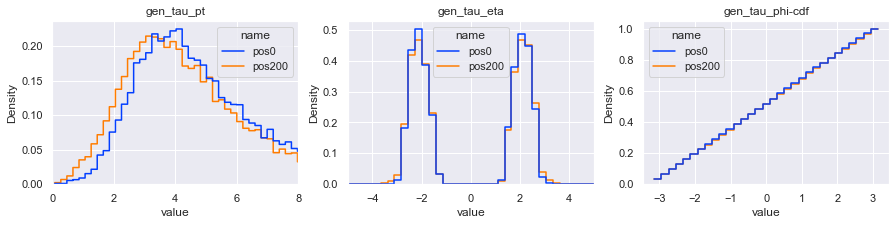

[INFO] Plotting mu_prop


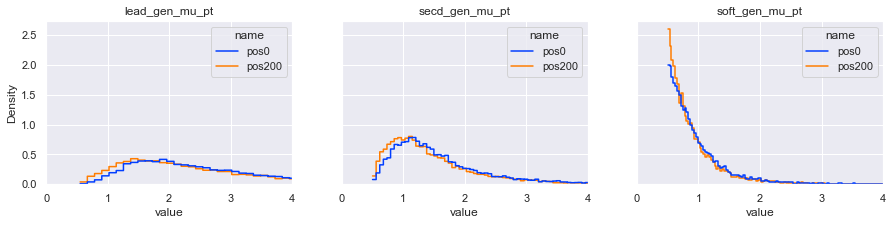

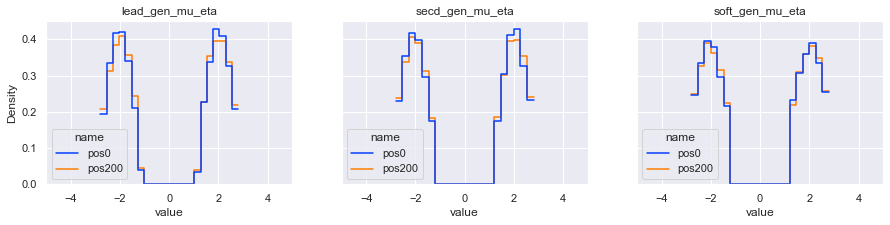

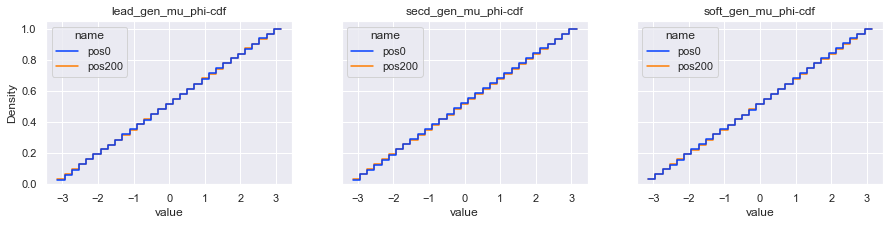

[INFO] Plotting mu_hits


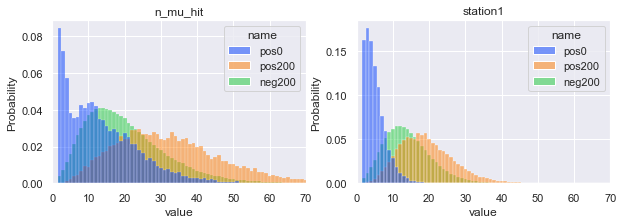

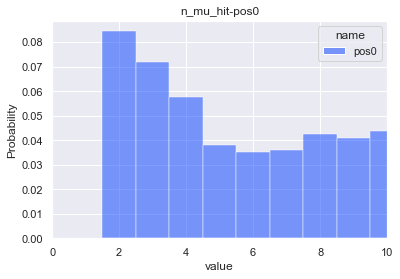

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:18<00:00,  6.11s/it]


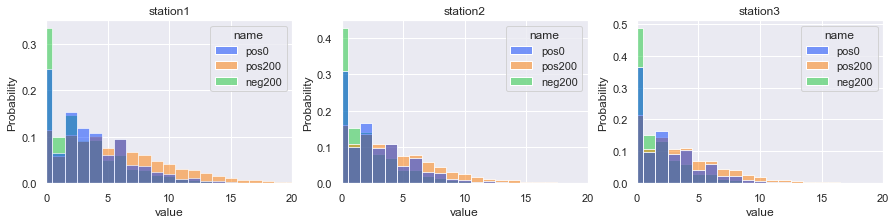

  0%|                                                                                                                                                        | 0/8 [00:00<?, ?it/s]

[INFO] Plotting sim_var...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:47<00:00, 13.38s/it]


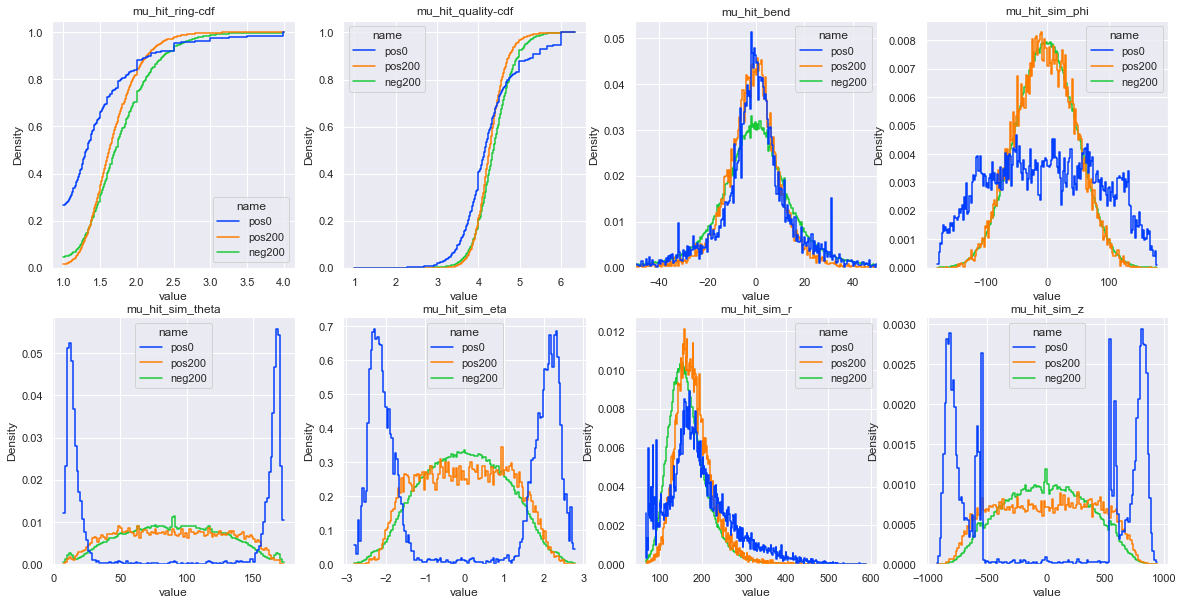

In [27]:
plot_tau_prop([pos0, pos200], ['pos0', 'pos200'])
plot_mu_prop([pos0, pos200], ['pos0', 'pos200'])
plot_mu_hits([pos0, pos200, neg200], ['pos0', 'pos200', 'neg200'])
plot_sim_var([pos0, pos200, neg200], ['pos0', 'pos200', 'neg200'])

[INFO] Plotting tau_prop


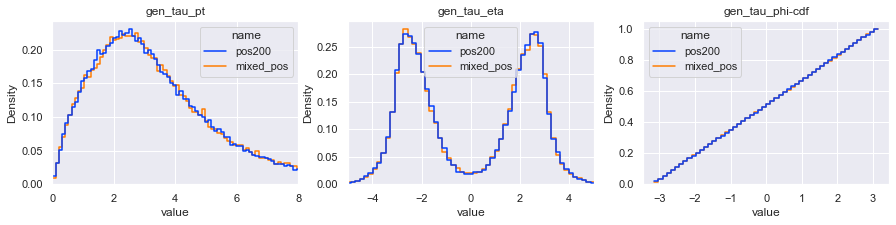

[INFO] Plotting mu_prop


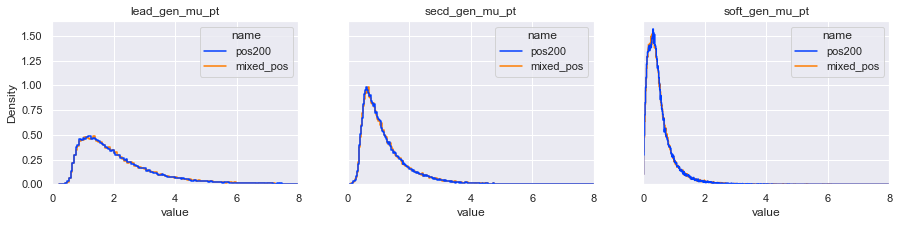

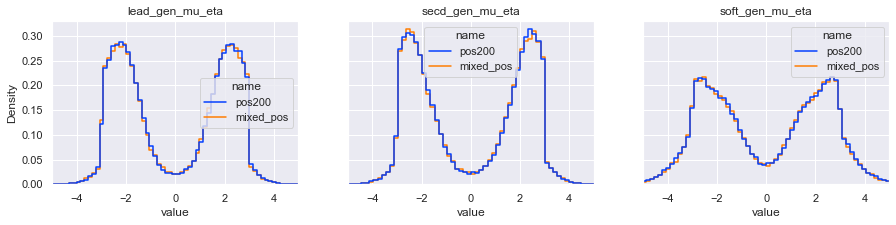

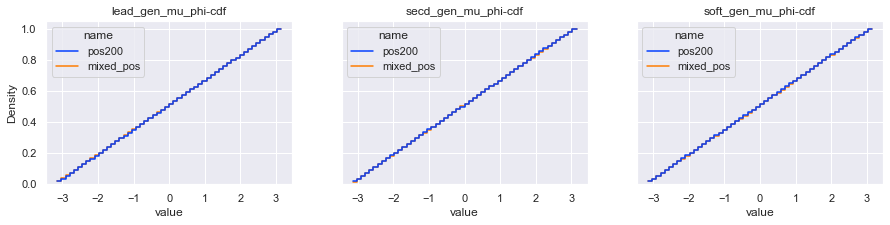

[INFO] Plotting mu_hits


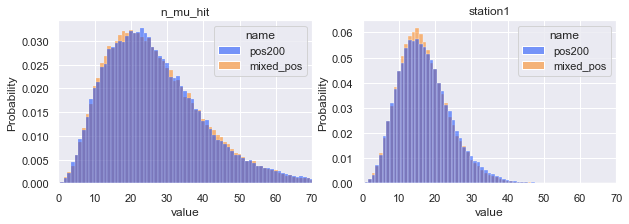

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.03s/it]


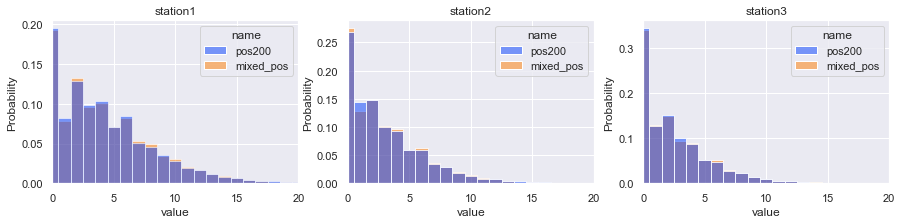

  0%|                                                                                                                                                        | 0/8 [00:00<?, ?it/s]

[INFO] Plotting sim_var...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:33<00:00,  4.19s/it]


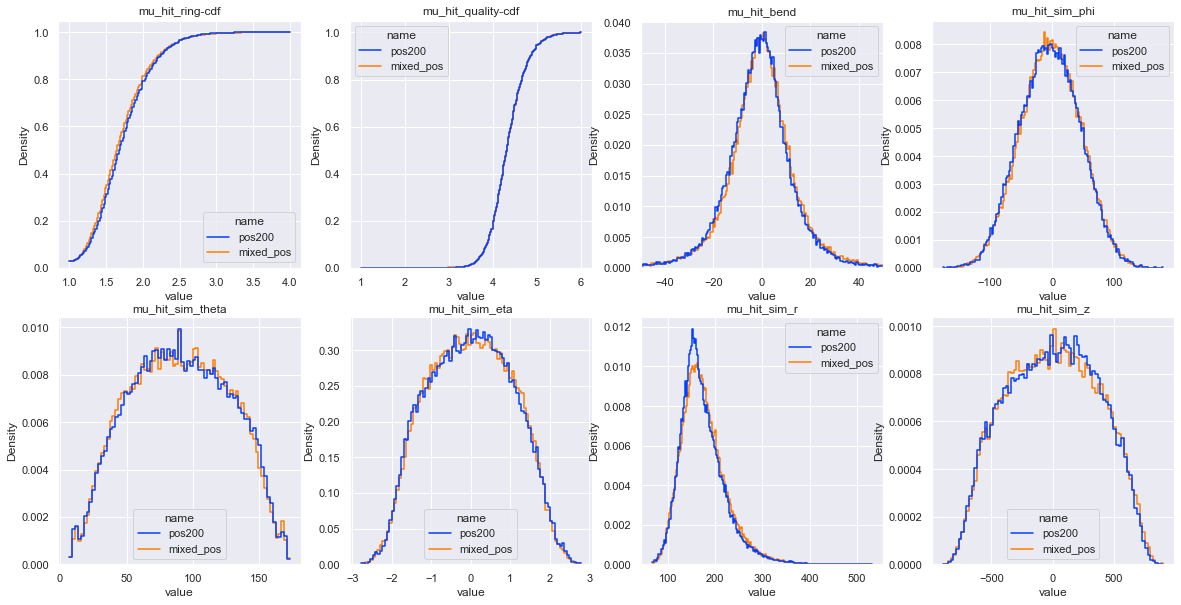

In [21]:
plot_tau_prop([pos200, mixed_pos], ['pos200', 'mixed_pos'])
plot_mu_prop([pos200, mixed_pos], ['pos200', 'mixed_pos'])
plot_mu_hits([pos200, mixed_pos], ['pos200', 'mixed_pos'])
plot_sim_var([pos200, mixed_pos], ['pos200', 'mixed_pos'])

  0%|                                                                                                                                                        | 0/8 [00:00<?, ?it/s]

[INFO] Plotting sim_var...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:16<00:00, 17.02s/it]


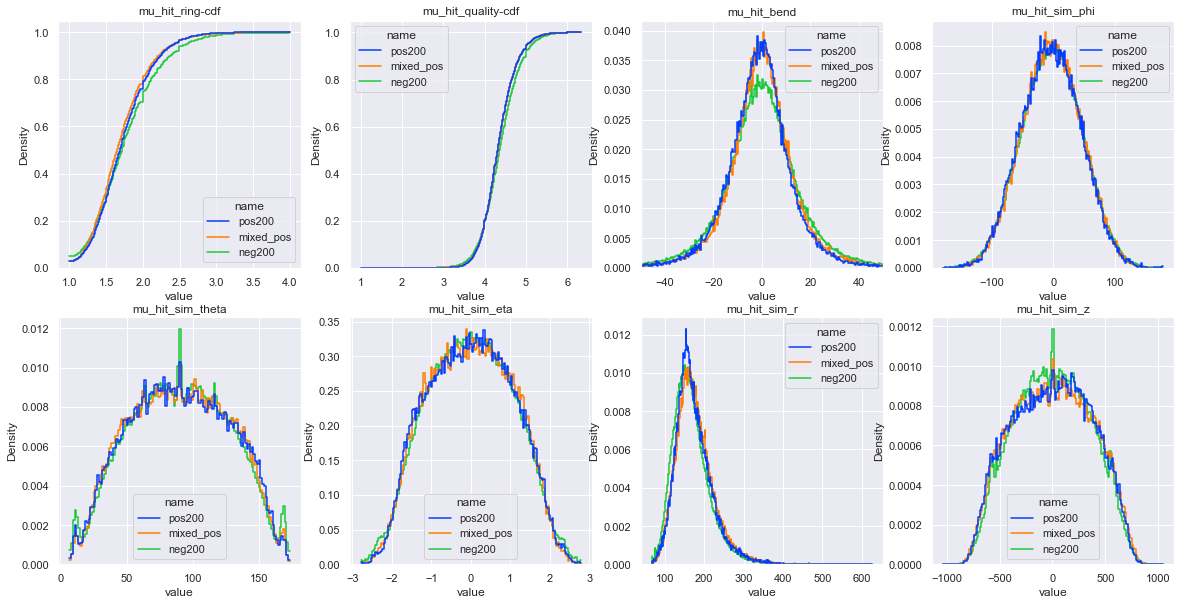

In [22]:
plot_sim_var([pos200, mixed_pos, neg200], ['pos200', 'mixed_pos', 'neg200'])

  0%|                                                                                                                                                        | 0/8 [00:00<?, ?it/s]

[INFO] Plotting sim_var...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:58<00:00, 14.80s/it]


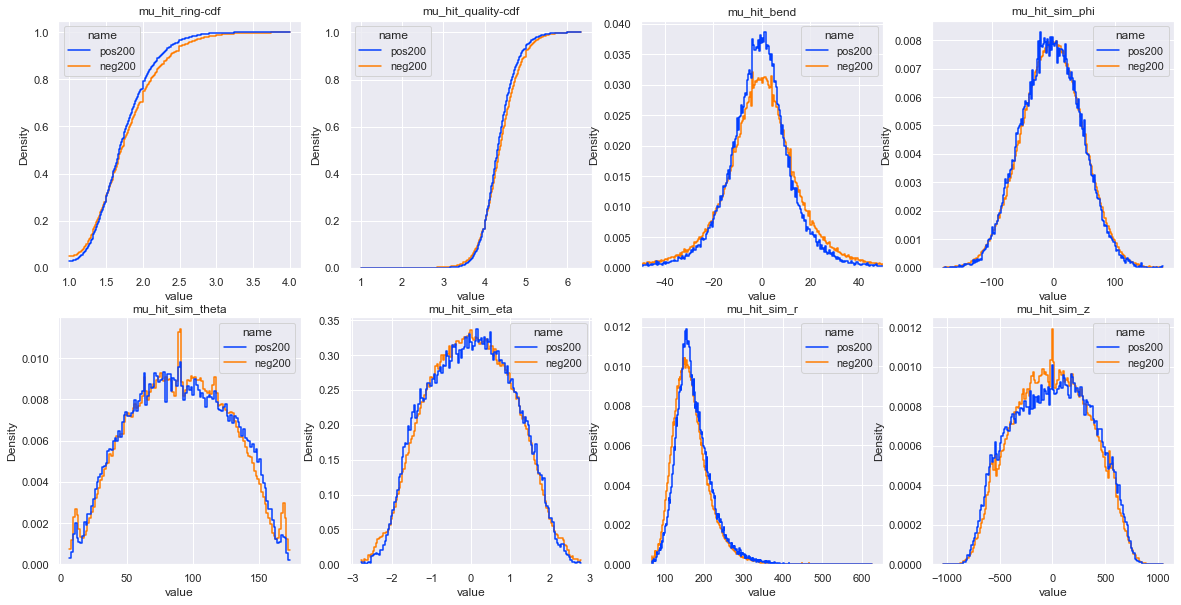

In [23]:
plot_sim_var([pos200, neg200], ['pos200', 'neg200'])

[INFO] Plotting mu_hits


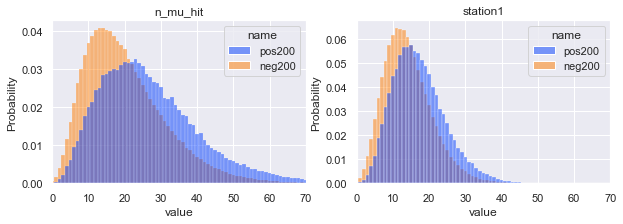

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:19<00:00,  6.44s/it]


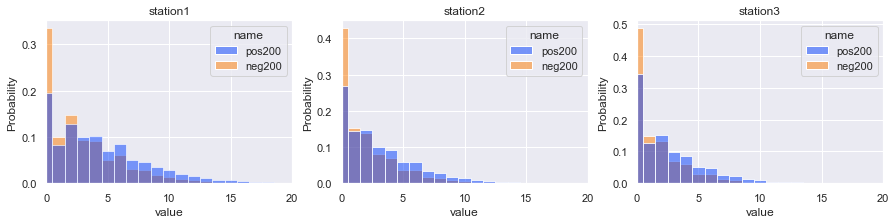

  0%|                                                                                                                                                        | 0/8 [00:00<?, ?it/s]

[INFO] Plotting sim_var...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:57<00:00, 22.20s/it]


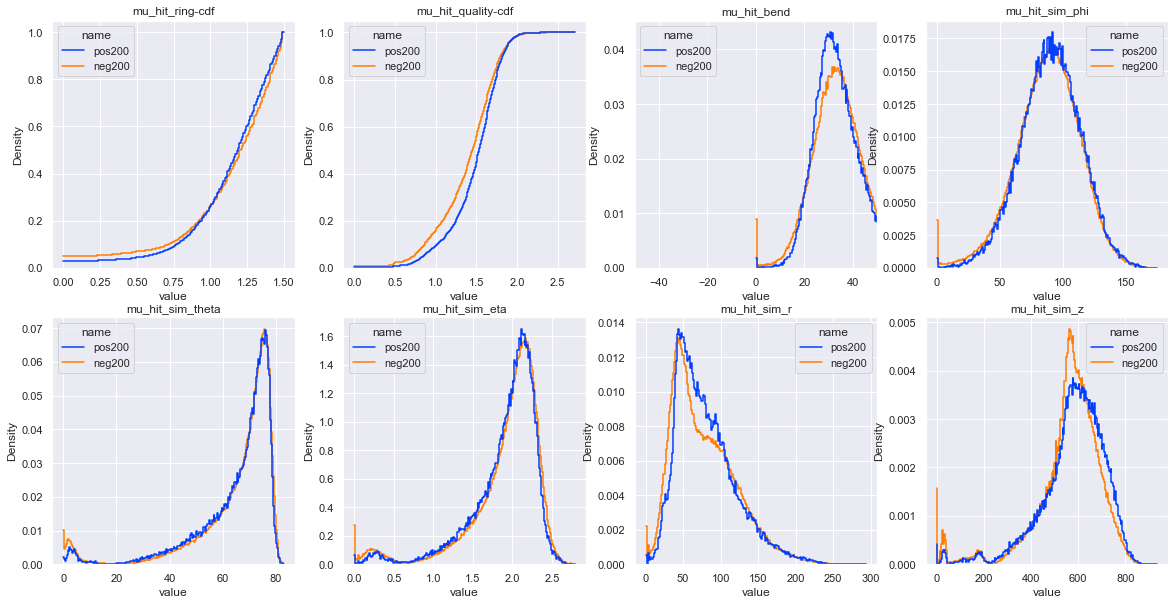

In [9]:
plot_mu_hits([pos200, neg200], ['pos200', 'neg200'])
plot_sim_var([pos200, neg200], ['pos200', 'neg200'], agg=np.std)

In [2]:
from main import Main
from utils.dataset import Tau3MuDataset
import yaml
import torch
from torch_geometric.data import Data, DataLoader

In [3]:
cfg = Path('./configs') / 'config0_station1_16layers_05-30focalloss_16pos2neg_fcdropout_rnn_500epoch_learnagg_moredropout_mixcheck_visz.yml'

cfg_dict = yaml.safe_load(cfg.open('r'))
m = Main(cfg_dict, '_'.join(cfg.stem.split('_')[1:]))

[Splits]
    train: 108583
    valid: 23267
    test: 23271
[INFO] Training accuracy lower bound:  0.501
[INFO] Data md5: 67a66fc19934d8698047e1485eb0b64a
[INFO] Number of trainable parameters: 1201185


In [4]:
m.load_checkpoint()

[INFO] Loading checkpoint from DeepGCN-05_30_2021-16_55_37-station1_16layers_05-30focalloss_16pos2neg_fcdropout_rnn_500epoch_learnagg_moredropout_mixcheck


In [5]:
data_loader = DataLoader(m.dataset, batch_size=2048, shuffle=False)

In [6]:
def eval_one_epoch(data_loader):
    loader_len = len(data_loader)
    
    all_probs = []
    for idx, data in enumerate(tqdm(data_loader)):
        loss_dict, probs, targets, lr = m.eval_one_batch(data.to(m.device))
        all_probs.append(probs)

    return torch.cat(all_probs).numpy().reshape(-1)

def hard_example_analysis(name):
    y_flag = y_flags[name]
    thres = threholds[name]
    
    idx = m.dataset.all_entries['y'] == y_flag
    probs = all_probs[idx]
    entries = m.dataset.all_entries[idx]
    
    if y_flag == 0:
        hard_examples = entries[probs > thres]
        easy_examples = entries[probs < thres]
    else:
        assert y_flag in [1, 2]
        hard_examples = entries[probs < thres]
        easy_examples = entries[probs > thres]

    
    if 'pos' in name:
        plot_tau_prop([hard_examples, easy_examples], ['hard_'+name, 'easy_'+name])
        plot_mu_prop([hard_examples, easy_examples], ['hard_'+name, 'easy_'+name])
    
    plot_mu_hits([hard_examples, easy_examples], ['hard_'+name, 'easy_'+name])
    plot_sim_var([hard_examples, easy_examples], ['hard_'+name, 'easy_'+name])

In [7]:
all_probs = eval_one_epoch(data_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [04:18<00:00,  1.08it/s]


In [8]:
pos200_dist = m.dataset.all_entries[m.dataset.all_entries['y'] == 1]
mixed_dist = m.dataset.all_entries[m.dataset.all_entries['y'] == 2]

  0%|                                                                                                                                                        | 0/8 [00:00<?, ?it/s]

[INFO] Plotting sim_var...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:31<00:00,  3.92s/it]


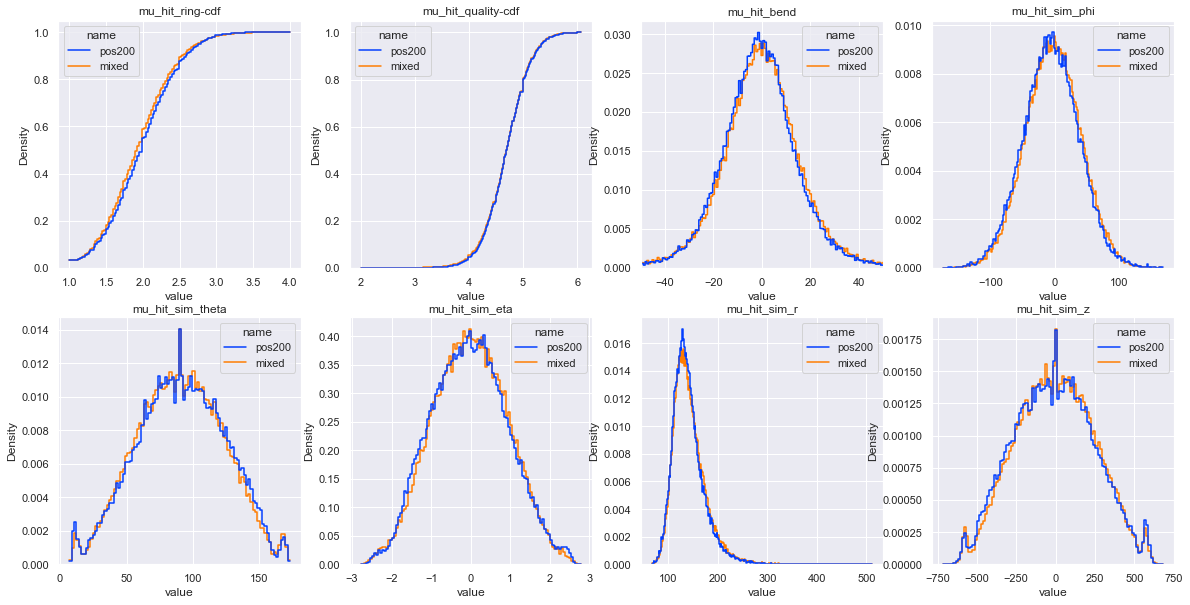

In [11]:
plot_sim_var([pos200_dist, mixed_dist], ['pos200', 'mixed'])

In [12]:
pos200_probs = all_probs[m.dataset.all_entries['y'] == 1]
neg200_probs = all_probs[m.dataset.all_entries['y'] == 0]
mixed_probs = all_probs[m.dataset.all_entries['y'] == 2]

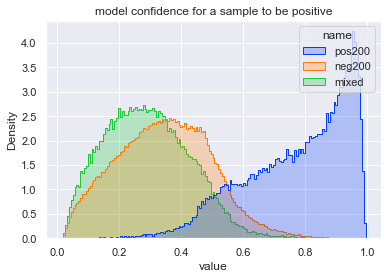

In [13]:
df = concat_array_to_df([pos200_probs, neg200_probs, mixed_probs], ['pos200', 'neg200', 'mixed'])
sns.histplot(data=df, x='value', hue='name', stat="density", fill=True, common_norm=False, discrete=False, element='step', palette=palette)

plt.title('model confidence for a sample to be positive')
plt.show()

In [14]:
threholds = {'mixed': 0.58, 'pos200': 0.58, 'neg200': 0.58}
y_flags = {'mixed': 2, 'pos200': 1, 'neg200': 0}

[INFO] Plotting tau_prop


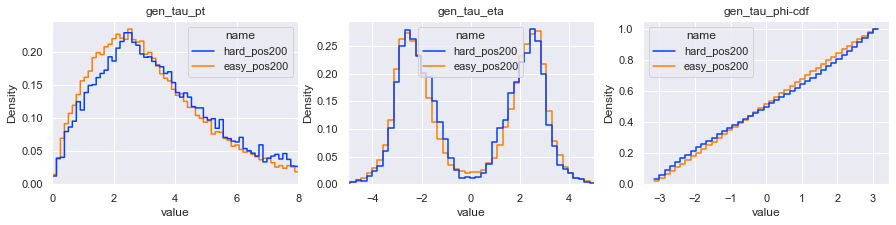

[INFO] Plotting mu_prop


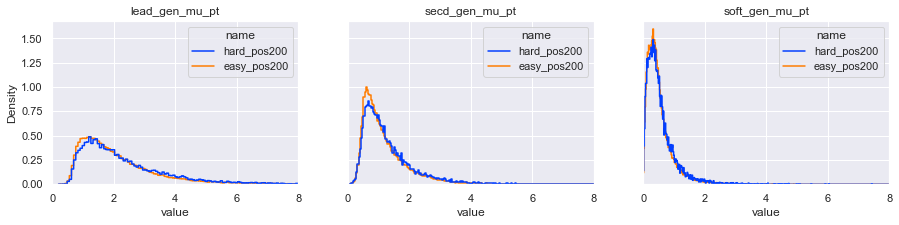

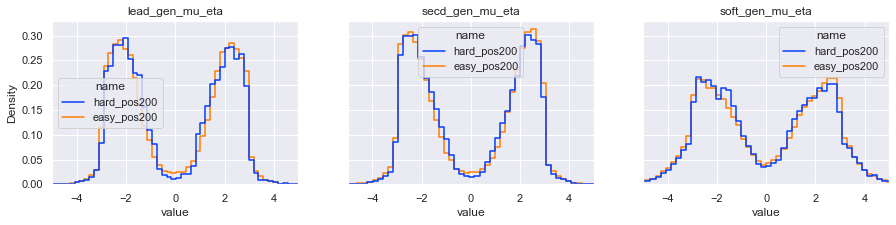

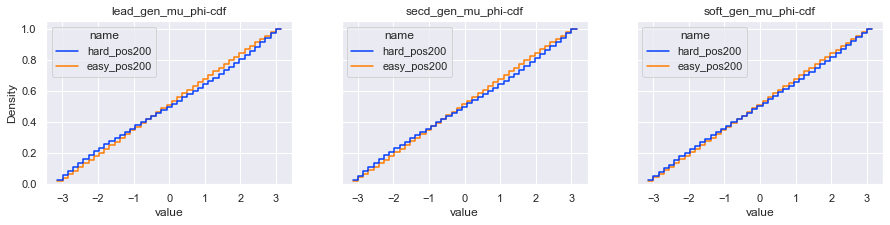

[INFO] Plotting mu_hits


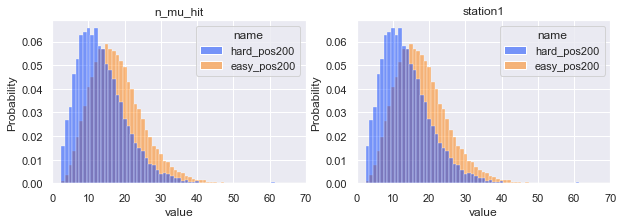

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s]


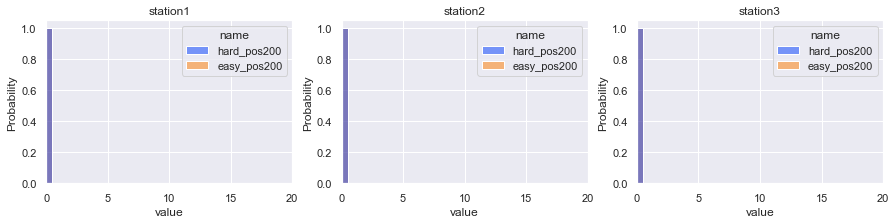

  0%|                                                                                                                                                        | 0/8 [00:00<?, ?it/s]

[INFO] Plotting sim_var...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:16<00:00,  2.02s/it]


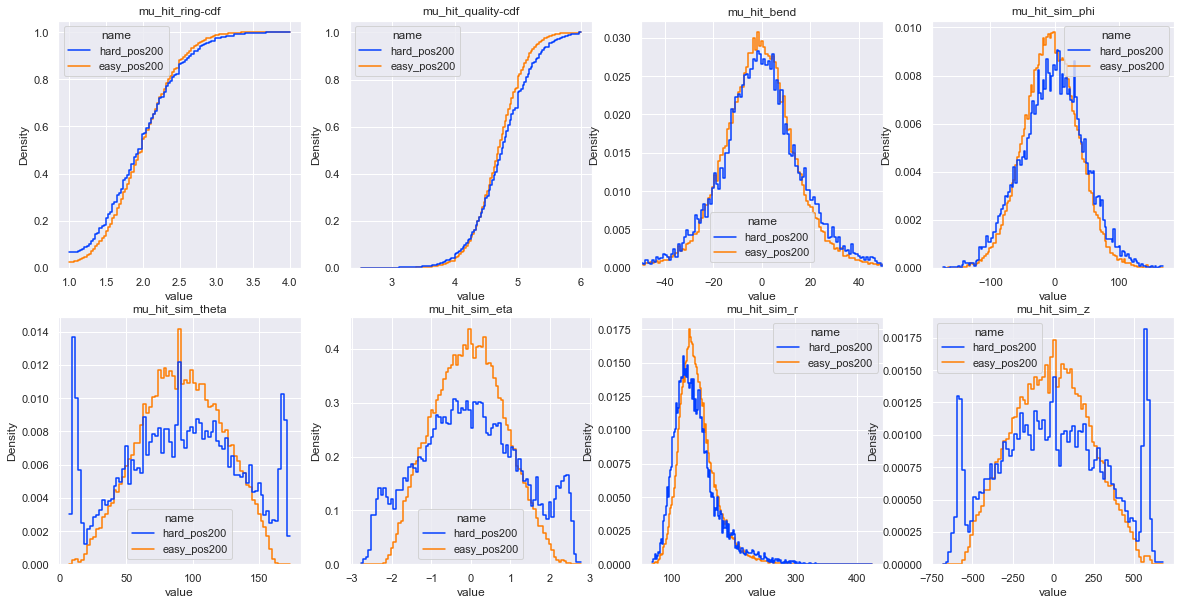

In [15]:
hard_example_analysis('pos200')

[INFO] Plotting mu_hits


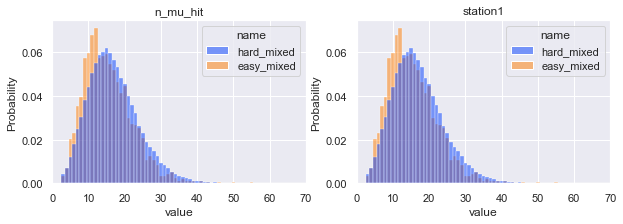

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


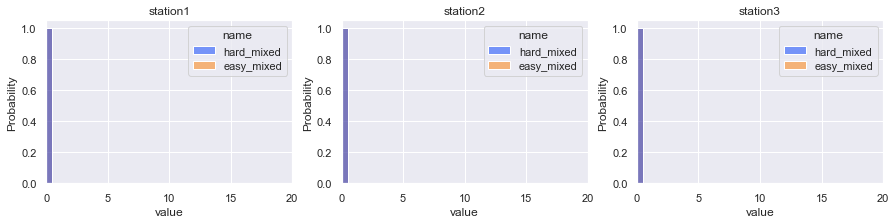

  0%|                                                                                                                                                        | 0/8 [00:00<?, ?it/s]

[INFO] Plotting sim_var...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:17<00:00,  2.20s/it]


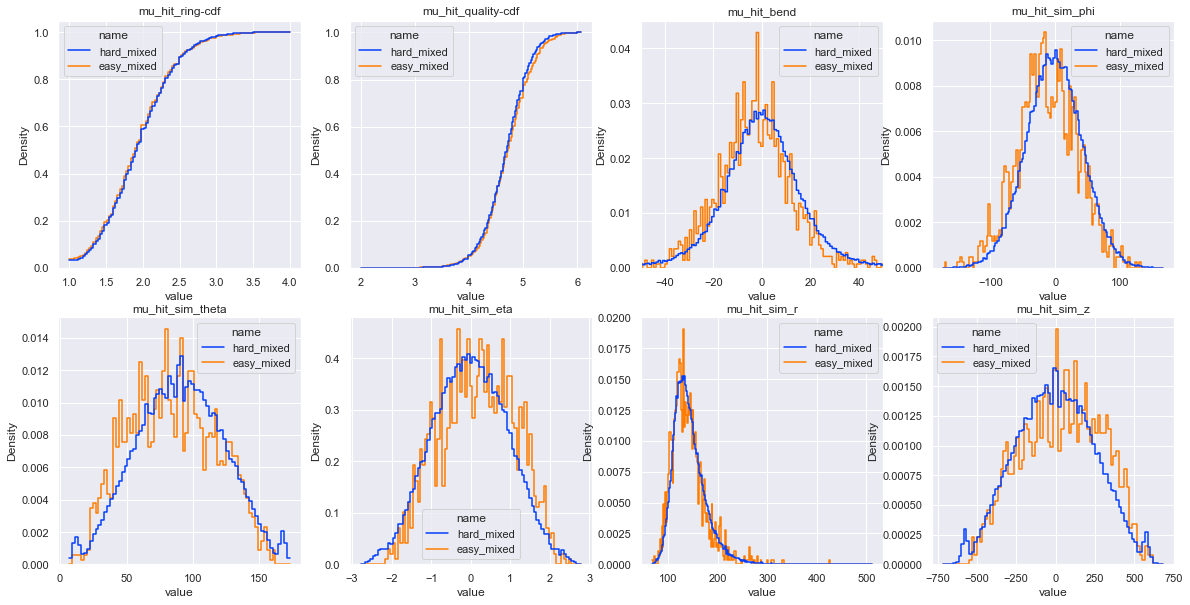

In [16]:
hard_example_analysis('mixed')

In [64]:
pos200_probs = all_probs[m.dataset.all_entries['y'] == 1]
neg200_probs = all_probs[m.dataset.all_entries['y'] == 0]
pos0_probs = all_probs[m.dataset.all_entries['y'] == 2]

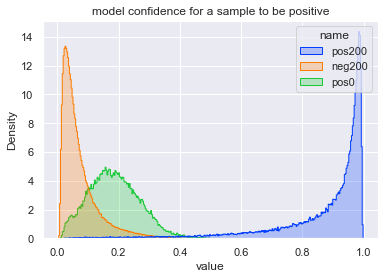

In [68]:
df = concat_array_to_df([pos200_probs, neg200_probs, pos0_probs], ['pos200', 'neg200', 'pos0'])
sns.histplot(data=df, x='value', hue='name', stat="density", fill=True, common_norm=False, discrete=False, element='step', palette=palette)

plt.title('model confidence for a sample to be positive')
plt.show()

In [ ]:
threholds = {'pos0': 0.1, 'pos200': 0.6, 'neg200': 0.6}
y_flags = {'pos0': 2, 'pos200': 1, 'neg200': 0}

[INFO] Plotting tau_prop


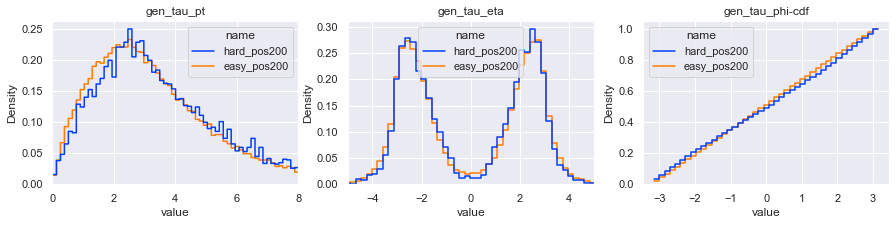

[INFO] Plotting mu_prop


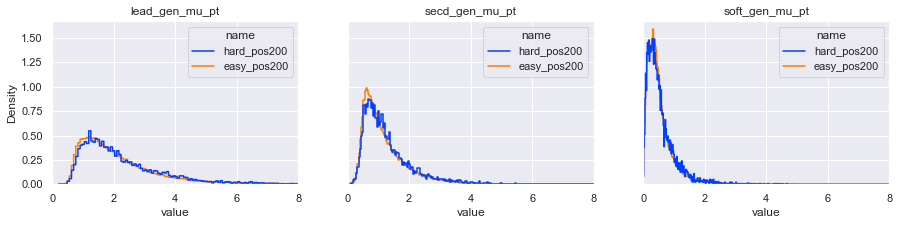

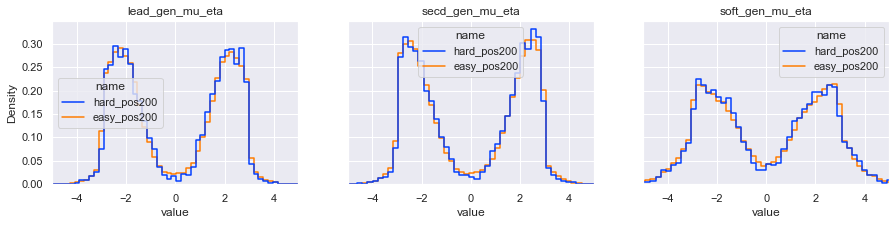

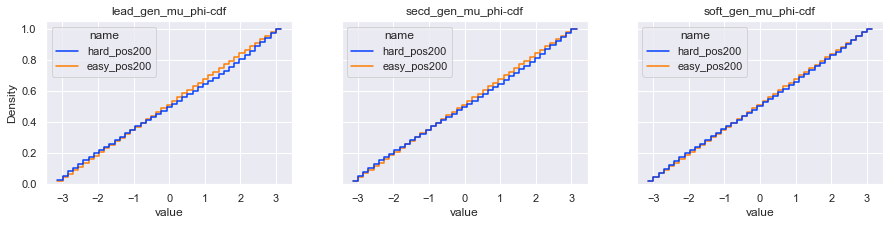

[INFO] Plotting mu_hits


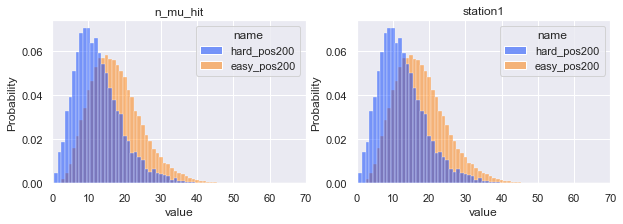

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


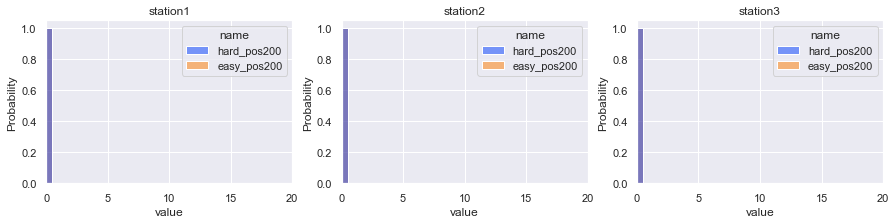

  0%|                                                                                                                                                        | 0/8 [00:00<?, ?it/s]

[INFO] Plotting sim_var...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:17<00:00,  2.19s/it]


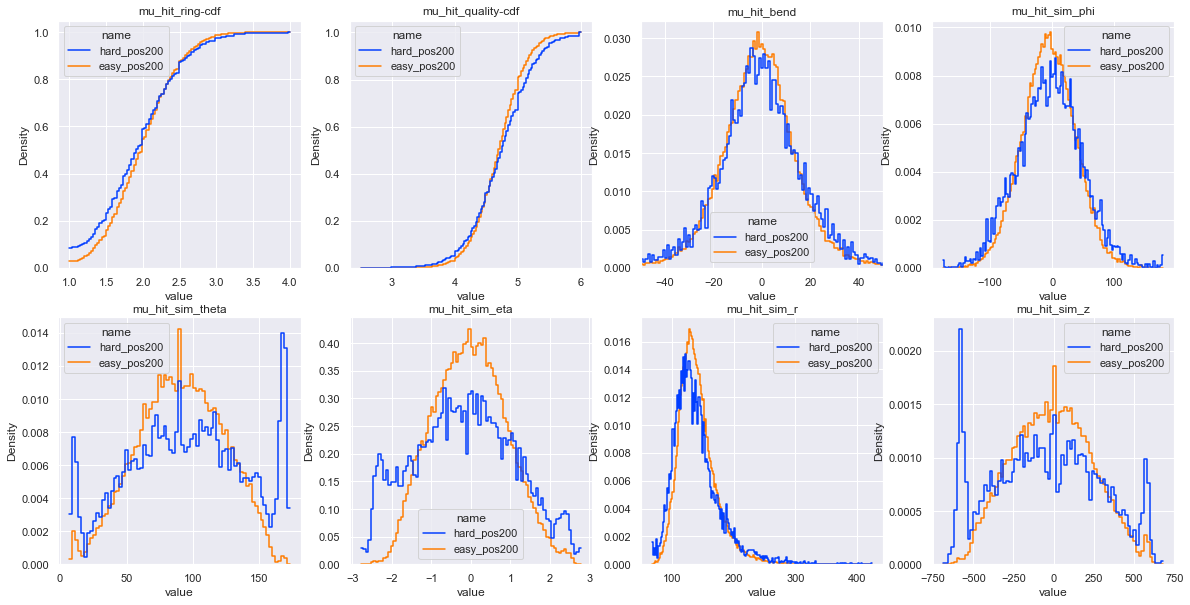

In [78]:
hard_example_analysis('pos200')

[INFO] Plotting tau_prop


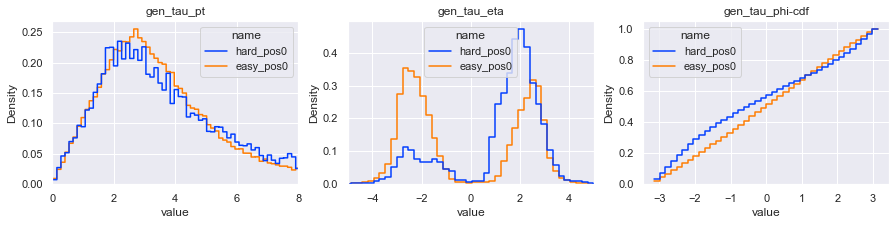

[INFO] Plotting mu_prop


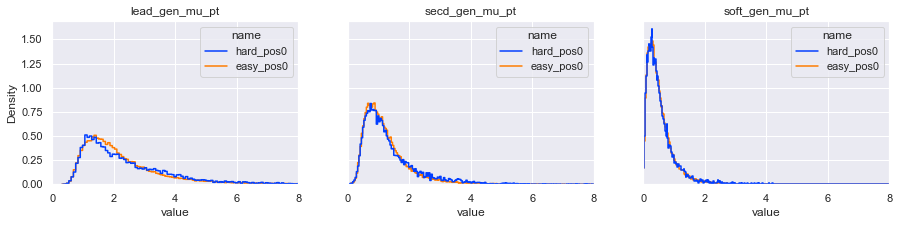

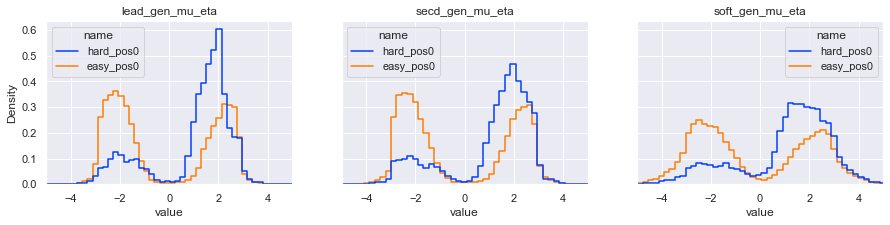

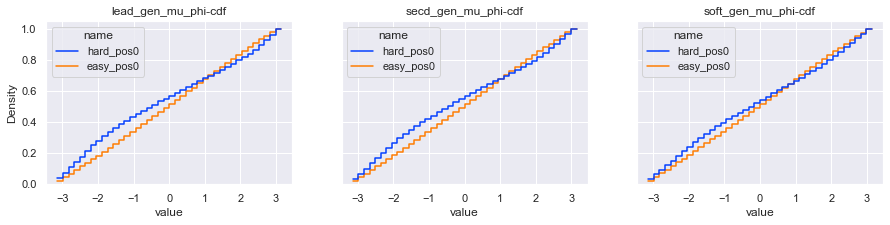

[INFO] Plotting mu_hits


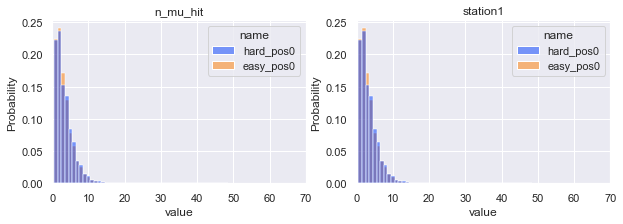

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.38it/s]


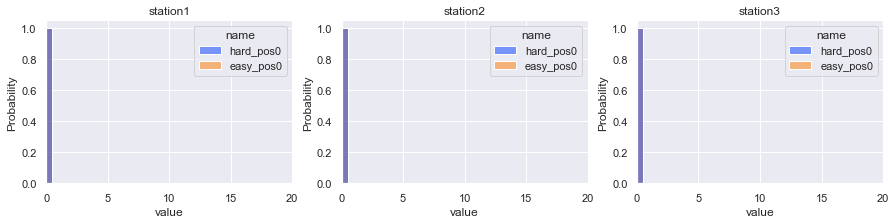

  0%|                                                                                                                                                        | 0/8 [00:00<?, ?it/s]

[INFO] Plotting sim_var...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.56s/it]


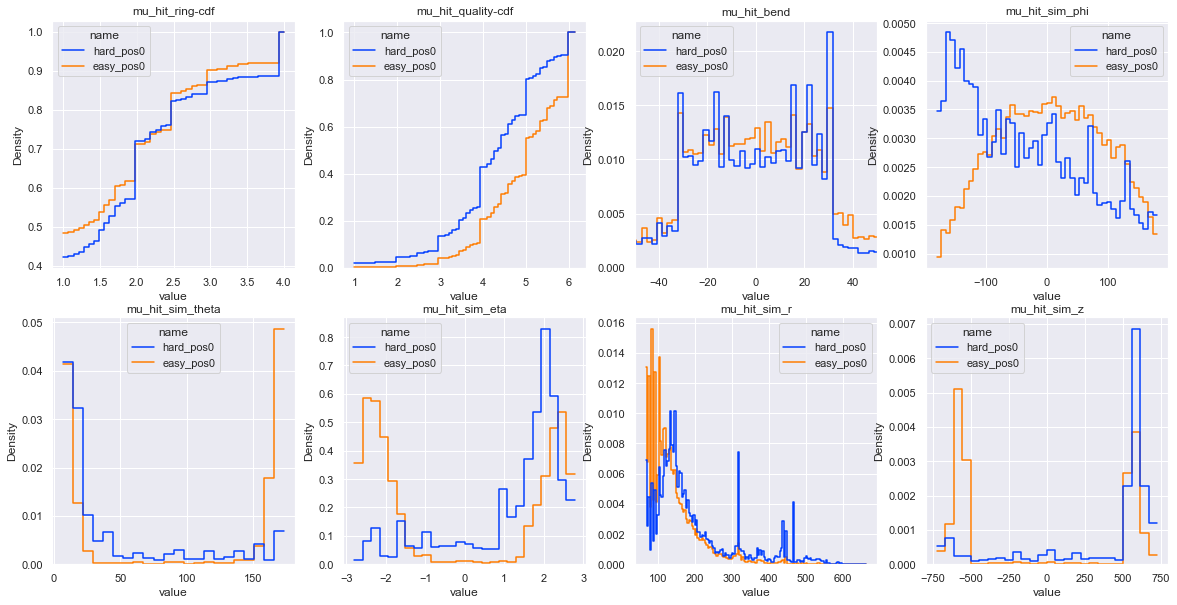

In [79]:
hard_example_analysis('pos0')

[INFO] Plotting mu_hits


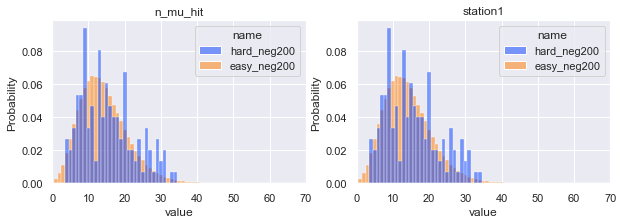

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.48s/it]


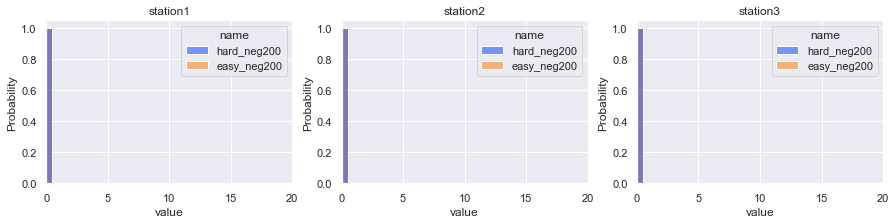

  0%|                                                                                                                                                        | 0/8 [00:00<?, ?it/s]

[INFO] Plotting sim_var...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:42<00:00, 12.84s/it]


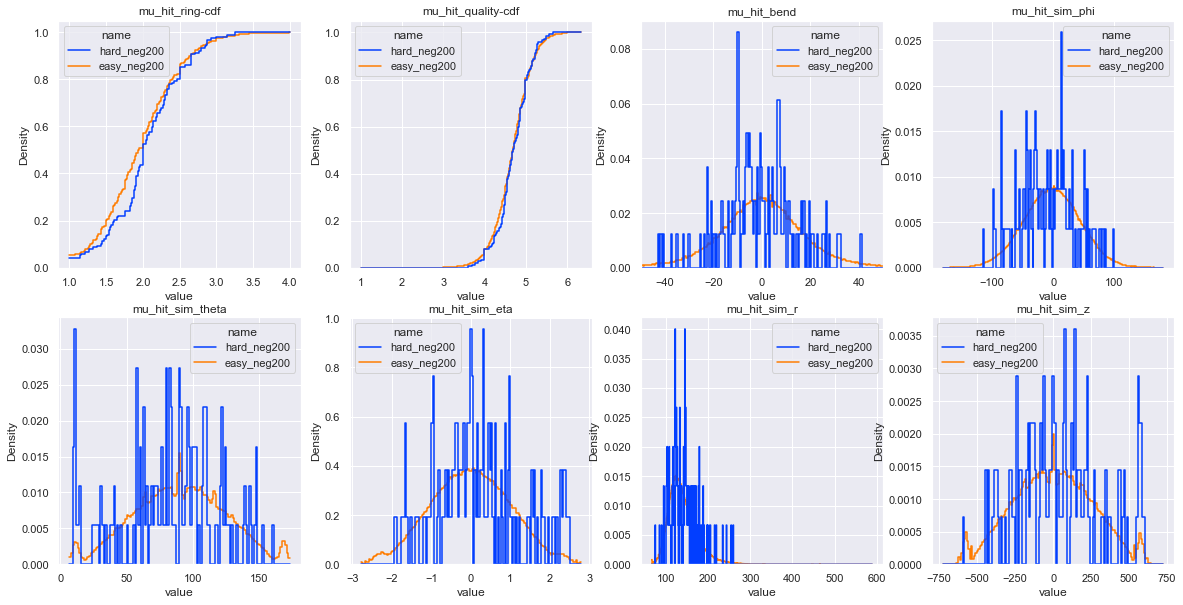

In [80]:
hard_example_analysis('neg200')

In [ ]:
## sanity check

# assert len(m.dataset.all_entries) == len(m.dataset)
# print(len(m.dataset))

# for idx, row in enumerate(tqdm(m.dataset.all_entries.itertuples(), total=len(m.dataset.all_entries))):
#     assert m.dataset[idx].x.shape[0] == (row.mu_hit_station == 1).sum() + 1

# conditions=m.config['data']['conditions']
# node_feature_names=m.config['data']['node_feature_names']
# edge_feature_names=m.config['data']['edge_feature_names']

# def process(entry_in):
#     entry = Tau3MuDataset.filter_hits(entry_in, conditions)
#     if entry is None:
#         return None

#     x, score_gt = Tau3MuDataset.get_node_features(entry, node_feature_names, virtual_node=True, mix_samples=False)

#     intra_level_edges, inter_level_edges, virtual_edges = Tau3MuDataset.build_graph(entry, add_self_loops=True)

#     intra_level_edge_features = Tau3MuDataset.get_edge_features(entry, intra_level_edges, edge_feature_names, for_virtual_edges=False)
#     inter_level_edge_features = Tau3MuDataset.get_edge_features(entry, inter_level_edges, edge_feature_names, for_virtual_edges=False)
#     virtual_edge_features = Tau3MuDataset.get_edge_features(entry, virtual_edges, edge_feature_names, for_virtual_edges=True)
    
#     return Data(x=x, num_nodes=x.shape[0], score_gt=score_gt,
#                 intra_level_edge_index=intra_level_edges,
#                 inter_level_edge_index=inter_level_edges,
#                 virtual_edge_index=virtual_edges,
#                 intra_level_edge_features=intra_level_edge_features,
#                 inter_level_edge_features=inter_level_edge_features,
#                 virtual_edge_features=virtual_edge_features)

# with torch.no_grad():
#     m.model.eval()

#     check_size = 1000
#     check_idx = np.random.choice(np.arange(0, len(m.dataset)), size=check_size, replace=False)
#     for idx in tqdm(check_idx):
#         data = process(m.dataset.all_entries.loc[idx])
#         pre_data = m.dataset[int(idx)]
#         assert abs(m.model(data.cuda())[0].item() - m.model(pre_data.cuda())[0].item()) < 0.0001